In [64]:
import pandas as pd
import seaborn as sns
import numpy as np
import geocoder
import gmaps
import statsmodels.api as sm

import pytz

import psycopg2

from sklearn.linear_model import Ridge

import spacy

import swifter

import matplotlib.patches as mpatches

In [65]:
# Plot settings
%pylab inline

figsize(15, 9)

import matplotlib.style as style

style.use('childsafeai')

Populating the interactive namespace from numpy and matplotlib


/home/rspectre/.virtualenvs/jupyter/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['maximum', 'randint']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [66]:
from local_settings import GOOGLE_API_KEY

gmaps.configure(GOOGLE_API_KEY)

### Retrieve Other Data

In [67]:
%store -r tests_df
%store -r citywide_all

# New York State Hospitalization / Discharge

## Processing

In [68]:
ny_state_hospitalization = pd.read_excel('data/new_york_state_hospitaliztion_and_discharge.xlsx')

In [69]:
ny_state_hospitalization['Cumulative Hospitalized'] = ny_state_hospitalization['Hospitalized'].cumsum() - ny_state_hospitalization['Discharged']

In [70]:
ny_state_hospitalization['Cumulative ICU'] = ny_state_hospitalization['ICU'].cumsum()
ny_state_hospitalization['Cumulative Intubations'] = ny_state_hospitalization['Intubations'].cumsum()
ny_state_hospitalization['Cumulative Discharged'] = ny_state_hospitalization['Discharged'].cumsum()

In [71]:
ny_state_hospitalization

,Date,Hospitalized,ICU,Intubations,Discharged,Deaths,New COVID Hospitalizations,Cumulative Hospitalized,Cumulative ICU,Cumulative Intubations,Cumulative Discharged
0,2020-03-16,91,0,NaN,0.0,0,NaN,91.0,0,NaN,0.0
1,2020-03-17,170,46,43.0,0.0,5,NaN,261.0,46,43.0,0.0
2,2020-03-18,121,33,27.0,123.0,0,NaN,259.0,79,70.0,123.0
3,2020-03-19,425,104,93.0,78.0,23,NaN,729.0,183,163.0,201.0
4,2020-03-20,364,77,69.0,102.0,9,489.0,1069.0,260,232.0,303.0
5,2020-03-21,637,143,116.0,150.0,70,823.0,1658.0,403,348.0,453.0
6,2020-03-22,586,140,124.0,145.0,0,776.0,2249.0,543,472.0,598.0
7,2020-03-23,714,135,121.0,150.0,96,909.0,2958.0,678,593.0,748.0
8,2020-03-24,736,215,192.0,278.0,75,1084.0,3566.0,893,785.0,1026.0
9,2020-03-25,1248,192,222.0,450.0,100,1796.0,4642.0,1085,1007.0,1476.0


## Analysis

In [72]:
tests_df[tests_df['state'] == 'NY'][['Date', 'hospitalizedCurrently', 'inIcuCurrently', 'onVentilatorCurrently']]

,Date,hospitalizedCurrently,inIcuCurrently,onVentilatorCurrently
37,2020-04-16,17735.0,5091.0,NaN
93,2020-04-15,18697.0,5225.0,NaN
149,2020-04-14,18697.0,5225.0,NaN
205,2020-04-13,18825.0,5156.0,NaN
261,2020-04-12,18707.0,5198.0,NaN
317,2020-04-11,18654.0,5009.0,NaN
373,2020-04-10,18569.0,4908.0,NaN
429,2020-04-09,18279.0,4925.0,NaN
485,2020-04-08,18079.0,4593.0,NaN
541,2020-04-07,17493.0,4593.0,NaN


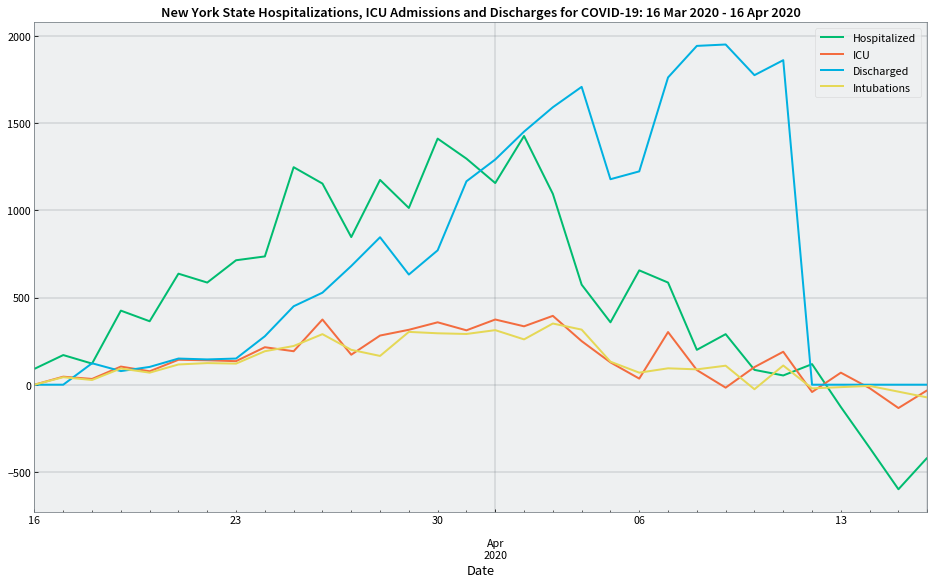

In [73]:
ny_state_hospitalization.groupby('Date')[['Hospitalized', 'ICU', 'Discharged', 'Intubations']].sum().plot(kind='line',
                                                                                           title="New York State Hospitalizations, ICU Admissions and Discharges for COVID-19: {0} - {1}".format(ny_state_hospitalization['Date'].min().date().strftime("%d %b %Y"),
                                                                                                                                                                                                 ny_state_hospitalization['Date'].max().date().strftime("%d %b %Y")))

In [74]:
ny_state_hospitalization.groupby('Date')[['Hospitalized', 'ICU', 'Discharged', 'Intubations']].sum().rolling(3)

Rolling [window=3,center=False,axis=0]

In [75]:
ny_state_hospitalization.groupby('Date')['Hospitalized'].sum().rolling(3).sum().max()

3881.0

Text(0, 0.5, 'New York City ER Visits')

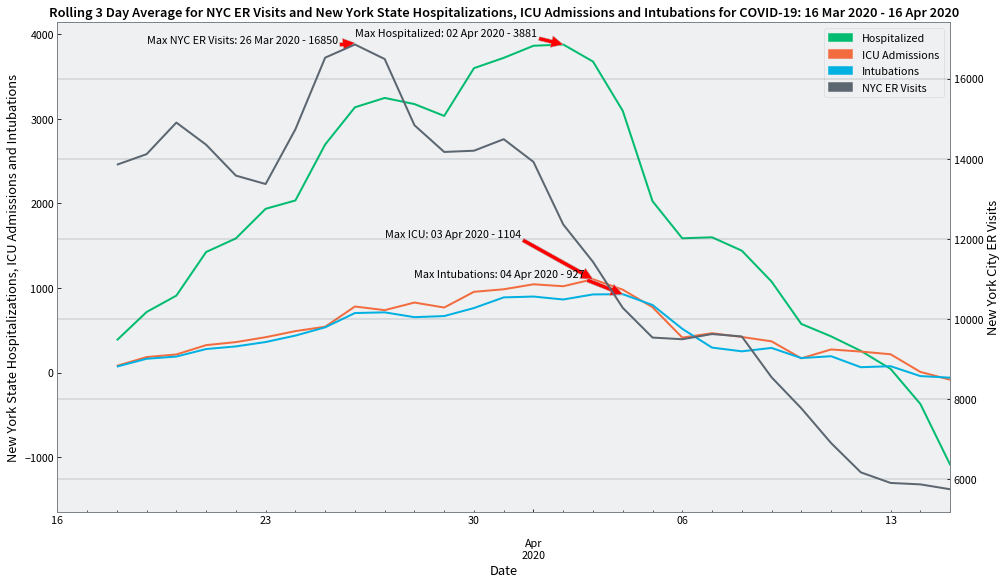

In [76]:
from datetime import timedelta
from random import randint

fig = plt.figure()
ax = fig.add_subplot(111)
ax1 = ax.twinx()

ny_state_hospitalization.groupby('Date')[['Hospitalized', 'ICU', 'Intubations']].sum().rolling(3).sum().plot(kind='line', ax=ax,
                                                                                           title="Rolling 3 Day Average for NYC ER Visits and New York State Hospitalizations, ICU Admissions and Intubations for COVID-19: {0} - {1}".format(ny_state_hospitalization['Date'].min().date().strftime("%d %b %Y"),
                                                                                                                                                                                                 ny_state_hospitalization['Date'].max().date().strftime("%d %b %Y")))

for condition in [{'Hospitalized': 100}, {'ICU': 500}, {'Intubations': 200}]:
    maximum = ny_state_hospitalization.groupby('Date')[list(condition.keys())[0]].sum().rolling(3).sum().max()
    max_index = ny_state_hospitalization.groupby('Date')[list(condition.keys())[0]].sum().rolling(3).sum().idxmax()

    ax.annotate("Max {0}: {1} - {2}".format(list(condition.keys())[0],
                                            max_index.strftime("%d %b %Y"),
                                            int(maximum)),
            xy=(max_index,
                maximum),
            xytext=(max_index - timedelta(days=7),
                    maximum + list(condition.values())[0]),
            arrowprops={'facecolor': 'red'})

ax.grid()
citywide_all[citywide_all['Date'] >= '2020-03-16'].groupby('Date')['Value'].sum().resample('D').sum().rolling(3).sum().plot(kind='line',
                                                                                                                            color="#5b6670",
                                                                                                                            secondary_y=False,
                                                                                                                            ax=ax1)

maximum = citywide_all[citywide_all['Date'] >= '2020-03-16'].groupby('Date')['Value'].sum().resample('D').sum().rolling(3).sum().max()
max_index = citywide_all[citywide_all['Date'] >= '2020-03-16'].groupby('Date')['Value'].sum().resample('D').sum().rolling(3).sum().idxmax()
ax.annotate("Max {0}: {1} - {2}".format("NYC ER Visits",
                                        max_index.strftime("%d %b %Y"),
                                        int(maximum)),
        xy=(max_index,
            3900),
        xytext=(max_index - timedelta(days=7),
                3900),
        arrowprops={'facecolor': 'red'})

patch = mpatches.Patch(color="gray", label="Other US States")
ax.legend(handles=[mpatches.Patch(color="#00bc70", label="Hospitalized"),
                   mpatches.Patch(color="#f36c3f", label="ICU Admissions"),
                   mpatches.Patch(color="#00b1e1", label="Intubations"),
                   mpatches.Patch(color="#5b6670", label="NYC ER Visits")])

ax.set_ylabel("New York State Hospitalizations, ICU Admissions and Intubations")
ax1.set_ylabel("New York City ER Visits")

In [77]:
tests_df[tests_df['state'] == 'NY'].groupby('Date')['death'].sum().diff().rolling(3).mean().idxmax()

Timestamp('2020-04-11 00:00:00')

Text(0, 0.5, 'New York City ER Visits')

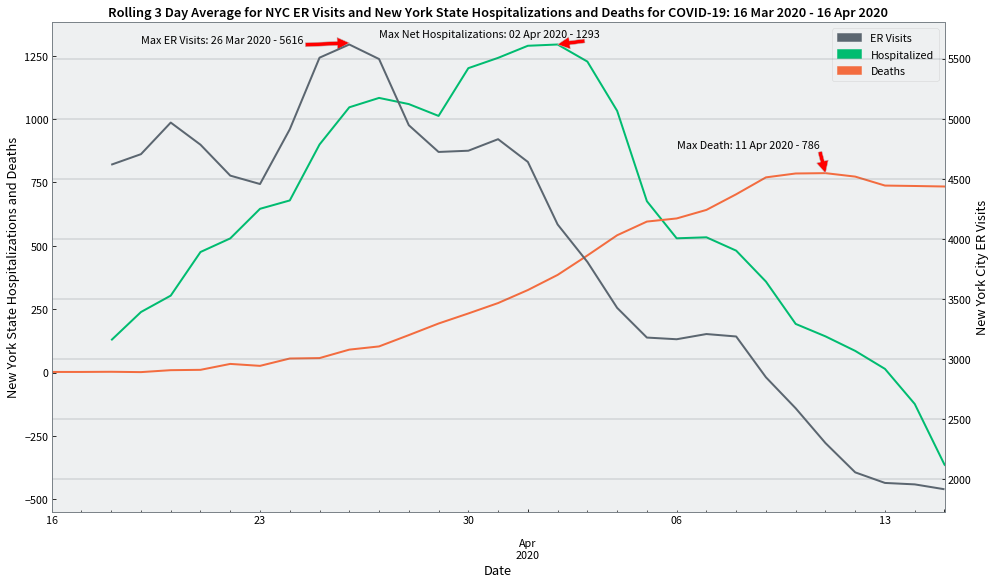

In [81]:
from datetime import timedelta
from random import randint

fig = plt.figure()
ax = fig.add_subplot(111)
ax1 = ax.twinx()

ny_state_hospitalization.groupby('Date')['Hospitalized'].sum().rolling(3).mean().plot(kind='line', ax=ax,
                                                                                     title="Rolling 3 Day Average for NYC ER Visits and New York State Hospitalizations and Deaths for COVID-19: {0} - {1}".format(ny_state_hospitalization['Date'].min().date().strftime("%d %b %Y"),
                                                                                                                                                                                                 ny_state_hospitalization['Date'].max().date().strftime("%d %b %Y")))

maximum = ny_state_hospitalization.groupby('Date')['Hospitalized'].sum().rolling(3).mean().max()
max_index = ny_state_hospitalization.groupby('Date')['Hospitalized'].sum().rolling(3).mean().idxmax()


ax.annotate("Max {0}: {1} - {2}".format('Net Hospitalizations',
                                        max_index.strftime("%d %b %Y"),
                                        int(maximum)),
        xy=(max_index,
            maximum),
        xytext=(max_index - timedelta(days=6),
                maximum + 30),
        arrowprops={'facecolor': 'red'})

tests_df[tests_df['state'] == 'NY'].groupby('Date')['death'].sum().diff().rolling(3).mean().plot(kind='line', ax=ax)

maximum = tests_df[tests_df['state'] == 'NY'].groupby('Date')['death'].sum().diff().rolling(3).mean().max()
max_index = tests_df[tests_df['state'] == 'NY'].groupby('Date')['death'].sum().diff().rolling(3).mean().idxmax()


ax.grid()

ax.annotate("Max {0}: {1} - {2}".format('Death',
                                        max_index.strftime("%d %b %Y"),
                                        int(maximum)),
        xy=(max_index,
            maximum),
        xytext=(max_index - timedelta(days=5),
                maximum + 100),
        arrowprops={'facecolor': 'red'})

citywide_all[citywide_all['Date'] >= '2020-03-16'].groupby('Date')['Value'].sum().resample('D').sum().rolling(3).mean().plot(kind='line',
                                                                                                                            color="#5b6670",
                                                                                                                            secondary_y=False,
                                                                                                                            ax=ax1)

maximum = citywide_all[citywide_all['Date'] >= '2020-03-16'].groupby('Date')['Value'].sum().resample('D').sum().rolling(3).mean().max()
max_index = citywide_all[citywide_all['Date'] >= '2020-03-16'].groupby('Date')['Value'].sum().resample('D').sum().rolling(3).mean().idxmax()
ax.annotate("Max {0}: {1} - {2}".format("ER Visits",
                                        max_index.strftime("%d %b %Y"),
                                        int(maximum)),
        xy=(max_index,
            1300),
        xytext=(max_index - timedelta(days=7),
                1300),
        arrowprops={'facecolor': 'red'})

patch = mpatches.Patch(color="gray", label="Other US States")
ax.legend(handles=[mpatches.Patch(color="#5b6670", label="ER Visits"),
                   mpatches.Patch(color="#00bc70", label="Hospitalized"),
                   mpatches.Patch(color="#f36c3f", label="Deaths")
                   ])

ax.set_ylabel("New York State Hospitalizations and Deaths")
ax1.set_ylabel("New York City ER Visits")

Text(0, 0.5, 'New York State New COVID Hospitalizations')

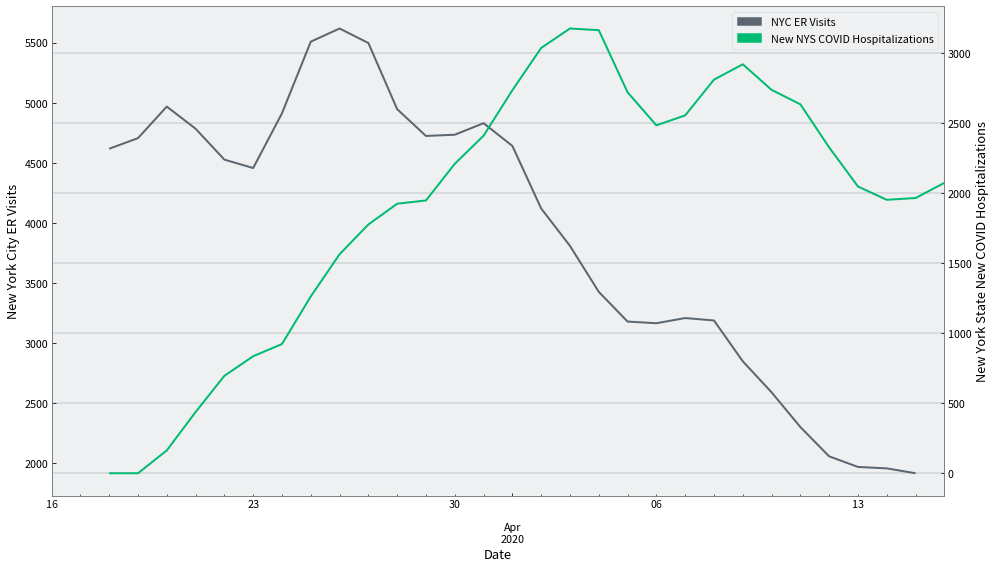

In [82]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax1 = ax.twinx()

citywide_all[citywide_all['Date'] >= '2020-03-16'].groupby('Date')['Value'].sum().resample('D').sum().rolling(3).mean().plot(kind='line',
                                                                                                                            color="#5b6670",
                                                                                                                            secondary_y=False,
                                                                                                                            ax=ax)

maximum = citywide_all[citywide_all['Date'] >= '2020-03-16'].groupby('Date')['Value'].sum().resample('D').sum().rolling(3).mean().max()
max_index = citywide_all[citywide_all['Date'] >= '2020-03-16'].groupby('Date')['Value'].sum().resample('D').sum().rolling(3).mean().idxmax()


ny_state_hospitalization.groupby('Date')['New COVID Hospitalizations'].sum().resample('D').sum().rolling(3).mean().plot(kind='line',
                                                                                                                        ax=ax1)

maximum = ny_state_hospitalization.groupby('Date')['New COVID Hospitalizations'].sum().resample('D').sum().rolling(3).mean().max()
max_index = ny_state_hospitalization.groupby('Date')['New COVID Hospitalizations'].sum().resample('D').sum().rolling(3).mean().idxmax()


ax.grid()


patch = mpatches.Patch(color="gray", label="Other US States")
ax.legend(handles=[mpatches.Patch(color="#5b6670", label="NYC ER Visits"),
                   mpatches.Patch(color="#00bc70", label="New NYS COVID Hospitalizations"),
                   ])

ax.set_ylabel("New York City ER Visits")
ax1.set_ylabel("New York State New COVID Hospitalizations")

Text(0.5, 1.0, 'Rolling 3-Day Average New York State COVID-19 Hospitalizations and Deaths (Source: NYS Department of Health)')

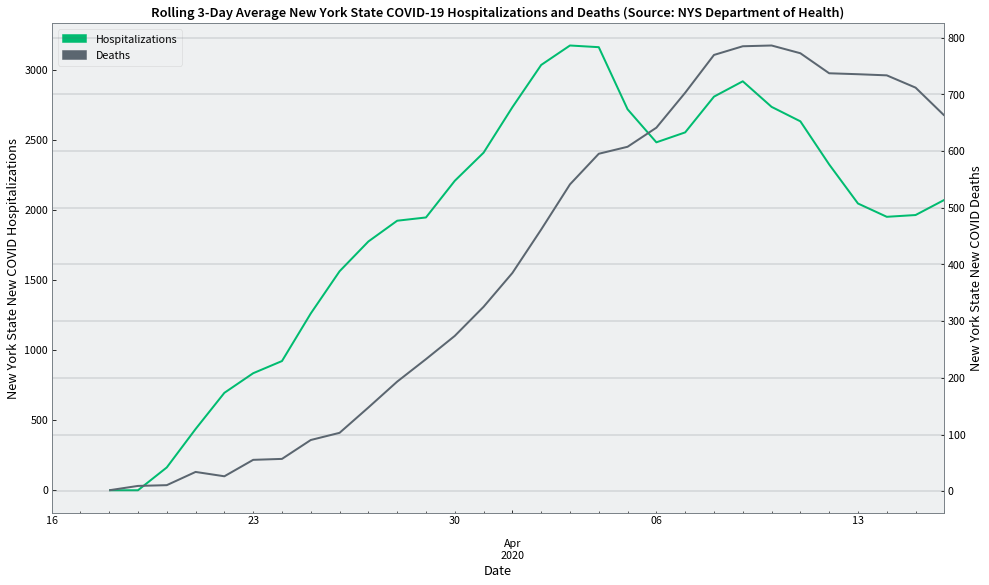

In [93]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax1 = ax.twinx()

ny_state_hospitalization.groupby('Date')['New COVID Hospitalizations'].sum().resample('D').sum().rolling(3).mean().plot(kind='line', color="#00bc70",
                                                                                                                        ax=ax)

maximum = ny_state_hospitalization.groupby('Date')['New COVID Hospitalizations'].sum().resample('D').sum().rolling(3).mean().max()
max_index = ny_state_hospitalization.groupby('Date')['New COVID Hospitalizations'].sum().resample('D').sum().rolling(3).mean().idxmax()


ny_state_hospitalization.groupby('Date')['Deaths'].sum().resample('D').sum().rolling(3).mean().plot(kind='line', color="#5b6670",
                                                                                                    ax=ax1)

maximum = ny_state_hospitalization.groupby('Date')['Deaths'].sum().resample('D').sum().rolling(3).mean().max()
max_index = ny_state_hospitalization.groupby('Date')['Deaths'].sum().resample('D').sum().rolling(3).mean().idxmax()


ax.grid()


ax.legend(handles=[mpatches.Patch(color="#00bc70", label="Hospitalizations"),
                   mpatches.Patch(color="#5b6670", label="Deaths"),
                   ], loc="upper left")

ax.set_ylabel("New York State New COVID Hospitalizations")
ax1.set_ylabel("New York State New COVID Deaths")
ax.set_title("Rolling 3-Day Average New York State COVID-19 Hospitalizations and Deaths (Source: NYS Department of Health)")


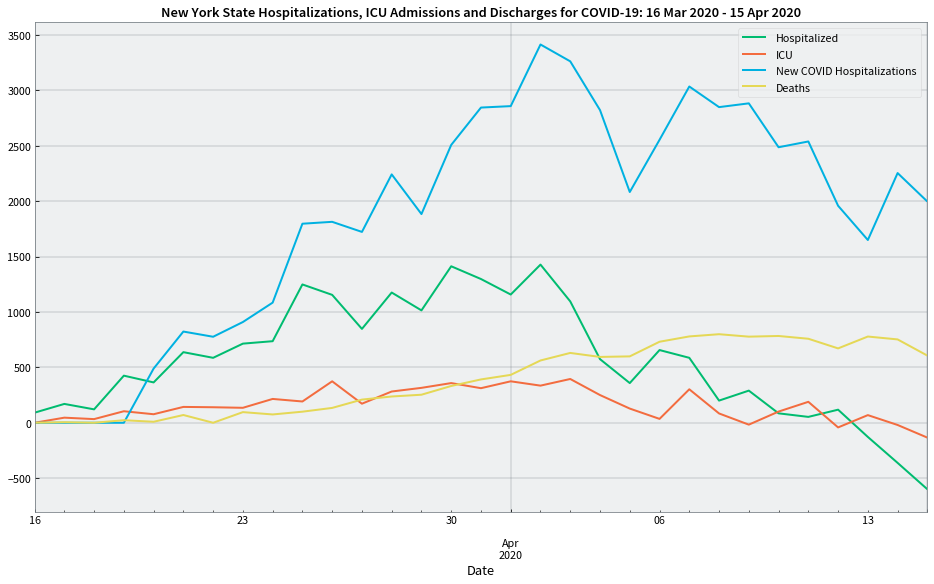

In [63]:
ax = ny_state_hospitalization.groupby('Date')[['Hospitalized', 'ICU', 'New COVID Hospitalizations', 'Deaths']].sum().plot(kind='line',
                                                                                  title="New York State Hospitalizations, ICU Admissions and Discharges for COVID-19: {0} - {1}".format(ny_state_hospitalization['Date'].min().date().strftime("%d %b %Y"),
                                                                                                                                                                                                 ny_state_hospitalization['Date'].max().date().strftime("%d %b %Y")))

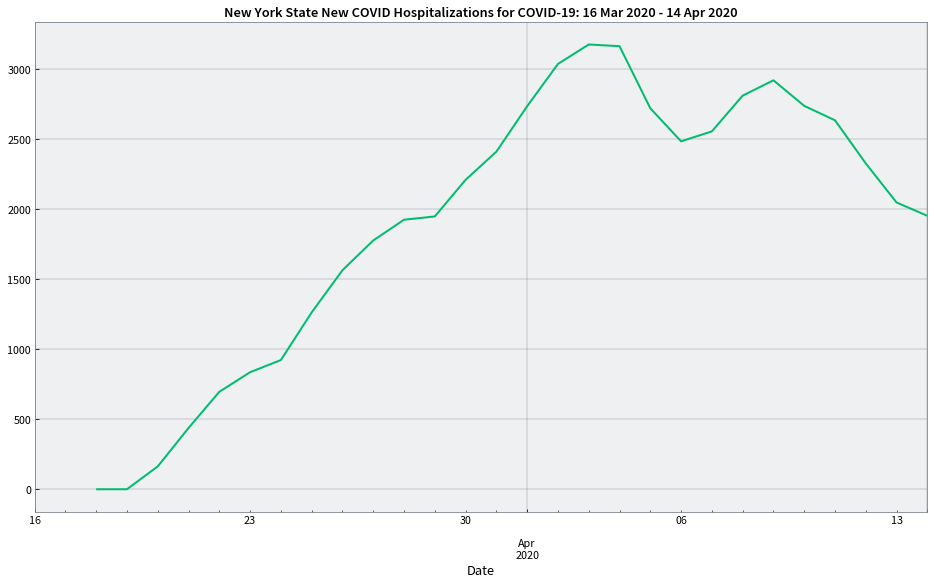

In [43]:
ax = ny_state_hospitalization.groupby('Date')['New COVID Hospitalizations'].sum().rolling(3).mean().plot(kind='line',
                                                                                   title="New York State New COVID Hospitalizations for COVID-19: {0} - {1}".format(ny_state_hospitalization['Date'].min().date().strftime("%d %b %Y"),
                                                                                                                                                                                                 ny_state_hospitalization['Date'].max().date().strftime("%d %b %Y")))

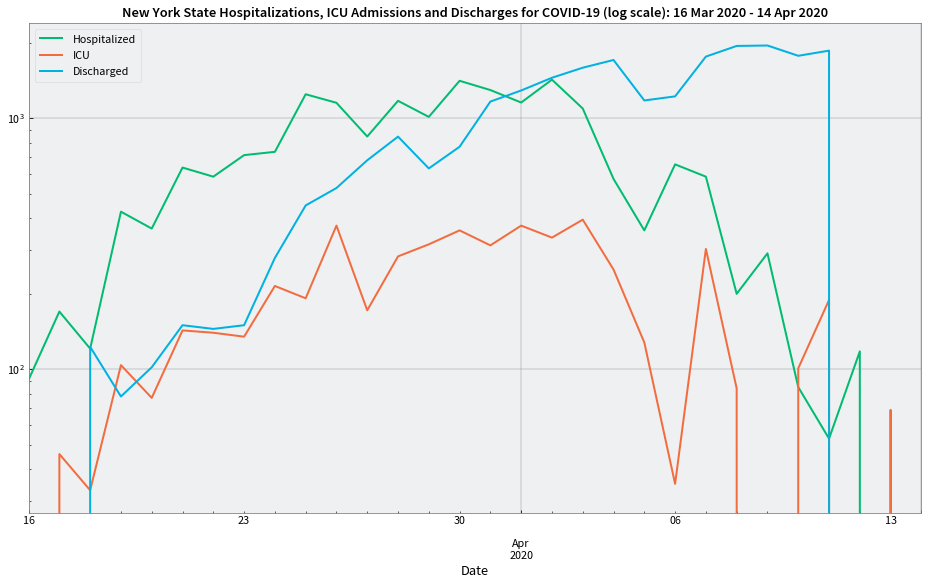

In [33]:
ny_state_hospitalization.groupby('Date')[['Hospitalized', 'ICU', 'Discharged']].sum().plot(kind='line', logy=True,
                                                                                           title="New York State Hospitalizations, ICU Admissions and Discharges for COVID-19 (log scale): {0} - {1}".format(ny_state_hospitalization['Date'].min().date().strftime("%d %b %Y"),
                                                                                                                                                                                                 ny_state_hospitalization['Date'].max().date().strftime("%d %b %Y")))

In [34]:
ny_state_hospitalization['Cumulative Hospitalized'] = ny_state_hospitalization['Hospitalized'].cumsum() - ny_state_hospitalization['Discharged']

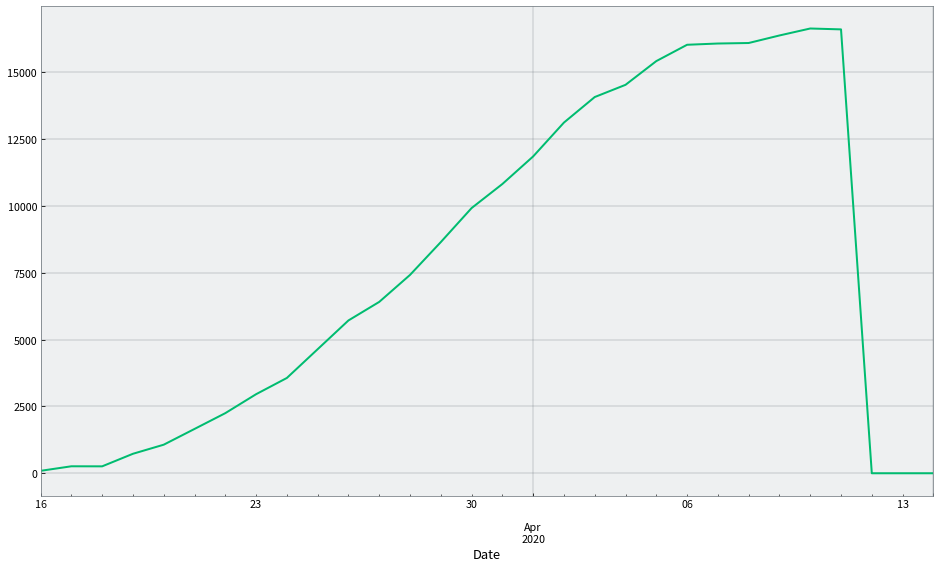

In [35]:
ny_state_hospitalization.groupby('Date')['Cumulative Hospitalized'].sum().plot(kind='line')

In [36]:
sns.regplot(y=ny_state_hospitalization.groupby('Date')['Hospitalized'].sum().resample('D').sum(),
            x=citywide_all[citywide_all['Date'] >= '2020-03-15'].groupby('Date')['Value'].sum().resample('D').sum())

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 31 and the array at index 1 has size 30

In [ ]:
(ny_state_hospitalization.groupby('Date')['Hospitalized'].sum() / citywide_all[citywide_all['Date'] >= '2020-03-16'].groupby('Date')['Value'].sum().resample('D').sum())

In [ ]:
(ny_state_hospitalization.groupby('Date')['Hospitalized'].sum() / citywide_all[citywide_all['Date'] >= '2020-03-16'].groupby('Date')['Value'].sum().resample('D').sum()).plot(kind='line')

In [ ]:
ax = tests_df[(tests_df['state'] == 'NY') & (tests_df['Date'] >= '2020-03-16')].groupby(['Date', 'state'])['positive'].max().unstack('state').plot(kind='line', color="#00bc70", label="Positive COVID-19 Tests", stacked=False)
ny_state_hospitalization.groupby('Date')['Cumulative Hospitalized'].sum().plot(kind='line', color="#00b1e1")
ny_state_hospitalization.groupby('Date')['Cumulative ICU'].sum().plot(kind='line', color="#f36c3f")
cases_by_county[(cases_by_county['state'] == 'New York') & (cases_by_county['date'] >= '2020-03-16')].groupby('date')['deaths'].sum().plot(kind='line', color="#788086")

In [ ]:
cases_by_county[cases_by_county['state'] == 'New York'].groupby('date')['deaths'].sum()